## Assignment 4 
<h1>Question :</h1>
You have been provided with Microchip data with two different quality assurance test results.
The third digit tells you whether the microchip has passed the quality assurance test (1 means
pass, 0 means fail) or not. <br>
1. Using raw data set as given, create three more features, and from there develop a GDA
model. Thereafter, utilize the same to predict whether a Microchip component will be
accepted or rejected. May use 70% data for training and 30 % data for testing.<br>
2. Using the same data set and features, and same 70% of the data for training and 30%
for testing, now use Box-Muller transformation to create a new data set having Gaussian
distribution within the range of the given data set and create a new Gaussian Discriminant
Analysis (GDA) model. Thereafter, utilize the model to predi\ct where a component will be
accepted or rejected using the testing data. <br>
3. Compare the performance of GDA in both the above cases and write a comparative analysis
report with results.


In [1]:
#loading required packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#reading data from file
read_data = np.genfromtxt("Data set for microchip quality Assurance 2019.csv",delimiter=',')

## Preprocessing and splitting dataset
1.Scaling data between(0-1).\
2.Shuffling data. \
3.Splitting into training(70%) and testing(30%). \
4.Separating x,y from data (first two column as x and third column as y).

In [3]:
read_data = (read_data-np.min(read_data,axis=0))/(np.max(read_data,axis=0)-np.min(read_data,axis=0)) #scaling data
np.random.shuffle(read_data)            # shuffling data
m,n = read_data.shape
p = int(m*0.7)

train_data = read_data[:p]             #splitting data into training and testing dataset
test_data = read_data[p:]
x_train = train_data[:,:-1]
y_train = train_data[:,-1:]
x_test = test_data[:,:-1]
y_test = test_data[:,-1:]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(82, 2) (82, 1) (36, 2) (36, 1)


### Plotting distribution of x1,x2

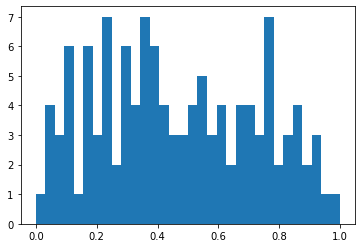

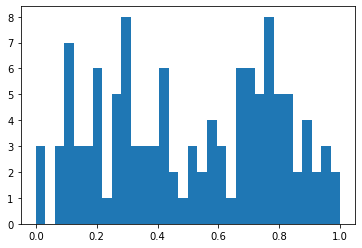

In [4]:
#Plotting distribution for feature x1,x2
x1,x2 = read_data[:,0],read_data[:,1]
plt.hist(x1,bins=32)
plt.show()
plt.hist(x2,bins=32)
plt.show()

### Plotting training dataset in 3D

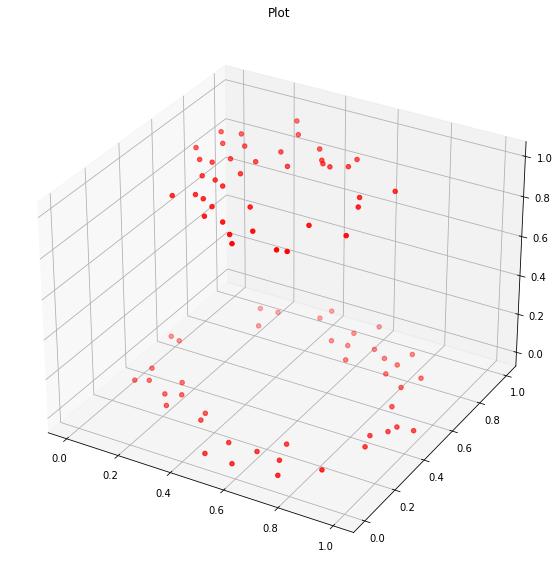

In [5]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(x_train[:,0],x_train[:,1],y_train[:,0],color='red')
ax.set_title('Plot')
plt.show()

### Calculating $\phi$ using the formula :
\begin{equation}
    \phi = \frac{1}{m} \sum _{i=1}^{i=m} y^{(i)}
\end{equation}

In [6]:
def calculate_phi(y):
    m,n = y.shape
    return np.sum(y)/m

print("->",calculate_phi(y_train))

-> 0.4878048780487805


### Calculating $\mu_0$ , $\mu_1$ using the formula :
\begin{equation}
    \mu_0 = \frac{\sum_{i=1}^{i=m}1(y^{(i)}=0)x^{(i)}}{\sum_{i=1}^{i=m}1(y^{(i)}=0)} \\
\end{equation}
\begin{equation}
    \mu_1 = \frac{\sum_{i=1}^{i=m}1(y^{(i)}=1)x^{(i)}}{\sum_{i=1}^{i=m}1(y^{(i)}=1)} 
\end{equation}

In [7]:
def calculate_mu0(x,y):
    m,n = x.shape
    num=np.zeros((1,n))
    den=0
    for i in range(m):
        if y[i]==0:
            num += x[i]
            den += 1
    #print(num)
    return num/den

def calculate_mu1(x,y):
    m,n = x.shape
    num=np.zeros((1,n))
    den=0
    for i in range(m):
        if y[i]==1:
            num += x[i]
            den += 1
    #print(num)
    return num/den

print("u0,u1 ->")
print(calculate_mu0(x_train,y_train))
print(calculate_mu1(x_train,y_train))

u0,u1 ->
[[0.52444652 0.49981989]]
[[0.42294399 0.491834  ]]


### Calculate $\sum$ using the formula:
\begin{equation}
    \sum = \frac{1}{m} \sum _{i=1}^{i=m} (x-\mu_{y_{(i)}}). (x-\mu_{y_{(i)}})^T
\end{equation}

In [8]:
def calculate_sigma(x,y,mu_0,mu_1):
    m,n = x.shape
    sigma = np.zeros((n,n))
    for i  in range(m):
        x_i = x[i]
        y_i = y[i]
        if y_i == 1:
            k = (x_i-mu_1).T
        else:
            k = (x_i-mu_0).T
        sigma += k*k.T
    sigma = sigma/m
    return sigma

print("sigma :")
calculate_sigma(x_train,y_train,calculate_mu0(x_train,y_train),calculate_mu1(x_train,y_train))

sigma :


array([[ 0.06333076, -0.0044287 ],
       [-0.0044287 ,  0.07622537]])

### Calculating class prior ,i.e class prior :P(y)
\begin{equation}
    P(y^{(i)};\phi) = \phi^{y^{(i)}} (1-\phi)^{1-y^{(i)}}
\end{equation}

In [9]:
def calculate_py(y_i,phi):
    if y_i==1:
        return phi
    else:
        return 1-phi

In [10]:
#using above function to find all required values
phi  = calculate_phi(y_train)
mu_0 = calculate_mu0(x_train,y_train)
mu_1 = calculate_mu1(x_train,y_train)
sigma = calculate_sigma(x_train,y_train,mu_0,mu_1)
print("phi ->",phi)
print("mu_0 ->",mu_0)
print("mu_1 ->",mu_1)
print("sigma ->\n",sigma)

phi -> 0.4878048780487805
mu_0 -> [[0.52444652 0.49981989]]
mu_1 -> [[0.42294399 0.491834  ]]
sigma ->
 [[ 0.06333076 -0.0044287 ]
 [-0.0044287   0.07622537]]


### Calculating Likelihood of a feature to be in a class ,i.e. P(x/y;$\mu,\sum$) using formula :
\begin{equation}
    P(x/y ; \mu , \sum) = \frac{1}{(2\pi)^{\frac{n}{2}}|\sum|^{\frac{1}{2}}} exp(-\frac{1}{2}(x-\mu)^T \sum^{-1} (x-\mu))
\end{equation}

In [11]:
def calculate_px_y(x,mu,sigma):
    m = x.shape[0]
    x = x.reshape(1,m)
    n = 2 #number of class
    x_u = (x-mu).T
    x_u_t = x_u.T
    det_sigma = np.linalg.det(sigma)
    inv_sigma = np.linalg.inv(sigma)
    np.matmul(np.matmul(x_u_t,inv_sigma),x_u)
    px_y = np.exp(-0.5*np.matmul(np.matmul(x_u_t,inv_sigma),x_u)) /( np.power((2*np.pi),n/2)* np.sqrt(det_sigma))
    return px_y


In [12]:
print(calculate_px_y(x_test[0],mu_1,sigma))
print(calculate_px_y(x_test[0],mu_0,sigma))

[[0.86478875]]
[[1.34205948]]


### Calculate P(y/x) for prediction:
\begin{equation}
   P(y/x) = \frac{P(x/y)P(y)}{P(x)} \\
   P(x) = constant\ for\ both\ class \\
   Prediction = argmax_y \frac{P(x/y)P(y)}{P(x)}
\end{equation}



In [13]:
def predict(x,phi,mu_0,mu_1,sigma):
    p0 = calculate_px_y(x,mu_0,sigma)*calculate_py(0,phi)
    p1 = calculate_px_y(x,mu_1,sigma)*calculate_py(1,phi)
    if p0>p1:
        return 0
    else:
        return 1

## Testing Accuracy (using Testing dataset) :

In [14]:
def accuracy(x_test,y_test,phi,mu_0,mu_1,sigma):
    m,n = x_test.shape
    count = 0
    for i in range(m):
        y_predict = predict(x_test[i],phi,mu_0,mu_1,sigma)
        if y_predict==y_test[i]:
            count +=1
    
    return count*100/m

print("Accuracy = ",accuracy(x_test,y_test,phi,mu_0,mu_1,sigma),end=" %")

Accuracy =  44.44444444444444 %

# feature x1,x2 to Normal Distribution using Box Muller Transformation :
x1_new  = (-2ln(x1)^1/2  * cos(2*3.141*x2)

x2_new = (-2ln(x1)^1/2  * sin(2*3.141*x2)

x1,x2 are uniform distribution and x1_new,x2_new are normal distribution

In [15]:
def boxMullerTransform(x1,x2):
    x1_fix = []
    for x_ in x1:
        if x_==0:
            x1_fix.append(x_+0.000001)      #0.000001 added to avoid log(0)
        else:
            x1_fix.append(x_)

    x1_fix = np.array(x1_fix).reshape(x1.shape)
    theta = 2*3.1415*x2

    sqrt_log_x1 = np.sqrt(-2*np.log(x1_fix))
    x1_new,x2_new = sqrt_log_x1*(np.cos(theta),np.sin(theta))
    return x1_new,x2_new

### Preprocessing and splitting data(for x1_new,x2_new) after applying Box muller transformation :

(82, 2) (82, 1) (36, 2) (36, 1)


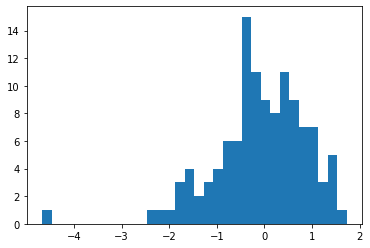

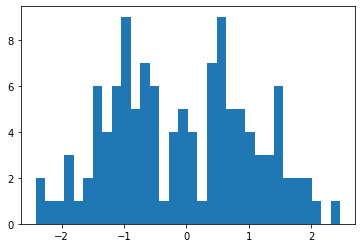

In [43]:
#same processes as done above, only one extra step for box muller algorithm
m,n = read_data.shape
p = int(m*0.7)
read_data_new = np.zeros((m,n))
read_data_new[:,:] = read_data[:,:]
x1,x2 = read_data_new[:,0],read_data_new[:,1]

#using Box Muller transformation
x1_new,x2_new = boxMullerTransform(x1,x2)
read_data_new[:,0] = x1_new
read_data_new[:,1] = x2_new

train_data_new = read_data_new[:p]             #splitting data into training and testing dataset
test_data_new = read_data_new[p:]
x_train_new = train_data_new[:,:-1]
y_train_new = train_data_new[:,-1:]
x_test_new = test_data_new[:,:-1]
y_test_new = test_data_new[:,-1:]
print(x_train_new.shape,y_train_new.shape,x_test_new.shape,y_test_new.shape)


plt.hist(x1_new,bins=32)
plt.show()
plt.hist(x2_new,bins=32)
plt.show()

### Calculating required values $\phi , \mu_0, \mu_1, \sum $ using new features 

In [41]:
phi_new  = calculate_phi(y_train_new)
mu_0_new = calculate_mu0(x_train_new,y_train_new)
mu_1_new= calculate_mu1(x_train_new,y_train_new)
sigma_new = calculate_sigma(x_train_new,y_train_new,mu_0_new,mu_1_new)
print("phi ->",phi_new)
print("mu_0 ->",mu_0_new)
print("mu_1 ->",mu_1_new)
print("sigma ->\n",sigma_new)

phi -> 0.4878048780487805
mu_0 -> [[0.13058468 0.08446866]]
mu_1 -> [[-0.40206856 -0.11114244]]
sigma ->
 [[0.90728365 0.09839206]
 [0.09839206 1.16422467]]


### Calculating Accuracy using Transformed features :

In [42]:
print("Accuracy = ",accuracy(x_test_new,y_test_new,phi,mu_0,mu_1,sigma),end=" %")

Accuracy =  55.55555555555556 %

## Analysis :
<ul>
    <li>1.Speed to perform task is very high compared to gradient descent</li>
    <li><b>2.Accuracy of prediction is higher(5-20)% when data is transformed through box muller transformation</b></li>
    <li>3.Input data size is very small, drawing conclusion is not easy.</li>
    <li>4.shuffling data changes Accuracy, nearly 5-6 %</li>
    <li>5.Precaution :Data has to be rescaled between 0-1 for feature x1,x2 as in box muller algorithm we have to take log,log of negative number gives error</li>
</ul>